# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

The task is to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [1]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random
import torch.nn as nn

In [2]:
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [3]:
# We prepared two datasets for training and evaluation
# Size of training data was set to 2048
# We test on 512

import torch

def prepare_data(num_samples=100):
    # Step 1: Generate integer sequences
    X_dna_seqs_train = list(rand_sequence(num_samples))

    # Step 2: Convert integer sequences to DNA sequences (ensure string output)
    temp = [''.join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs_train]  # Convert map objects to strings

    # Step 3: Count CG pairs in DNA sequences
    y_dna_seqs = [count_cpgs(seq) for seq in temp]

    return X_dna_seqs_train, y_dna_seqs


train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

In [4]:
#Generating a sample from the test data to use later to make predictions
sample2 = ''.join(intseq_to_dnaseq(train_x[0]))
count_cpgs(sample2), sample2

(5,
 'CCAAAAAANTACNGATNCANCGGACCAGTTGCGCNCTCGTTAGGTACAATCCCGCTCGATGTATAACANGGGNGNAAGGCAGCCACTATAGATNTTNCTTCACAATNAANGTTTNGCNTNACNGCCTT')

In [5]:
# Define the number of classes
num_classes = 5

# Convert each element in the original_data to one-hot encoding
train_x= [[[1 if i == value else 0 for i in range(num_classes)] for value in sublist] for sublist in train_x]
test_x= [[[1 if i == value else 0 for i in range(num_classes)] for value in sublist] for sublist in test_x]

In [6]:
# Converting data to torch tensors

train_x=np.array(train_x)
train_y=np.array(train_y)
test_x=np.array(test_x)
test_y=np.array(test_y)

# train_x=train_x.reshape((-1,128,1))
train_y=train_y.reshape((-1,1))
# test_x=test_x.reshape((-1,128,1))
test_y=test_y.reshape((-1,1))

train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
test_x = torch.tensor(test_x).float()
test_y = torch.tensor(test_y).float()

train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([2048, 128, 5]),
 torch.Size([2048, 1]),
 torch.Size([512, 128, 5]),
 torch.Size([512, 1]))

In [7]:
#  To organize and encapsulate the data in a way that is compatible with PyTorch's data loading utility
from torch.utils.data import Dataset, DataLoader

class DNA_Sequence(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = DNA_Sequence(train_x, train_y)
test_dataset = DNA_Sequence(test_x, test_y)

# Create data loaders for training and test data
batch_size=32
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Select the device, make sure that cuda is available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [9]:
# To check the shape after fitting the data in data loader
for _, batch in enumerate(train_data_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 128, 5]) torch.Size([32, 1])


In [10]:
# The LSTM model used for prediction
import torch
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self, input_size=5, cnn_channels=128, kernel_size=2, hidden_size=128, num_stacked_layers=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # 2 CNN layers
        self.conv1d_1 = nn.Conv1d(input_size, cnn_channels, kernel_size)
        self.relu_1 = nn.ReLU()
        self.maxpool_1 = nn.MaxPool1d(kernel_size=1)

        self.conv1d_2 = nn.Conv1d(cnn_channels, cnn_channels, kernel_size)
        self.relu_2 = nn.ReLU()
        self.maxpool_2 = nn.MaxPool1d(kernel_size=1)

        # LSTM layer
        self.lstm = nn.LSTM(126, hidden_size, num_stacked_layers,
                            batch_first=True, dropout=0.5, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size*2, 1)
        self.dropout = nn.Dropout(0.2)

        # The CNN layers are esential as they act as a feature extraction, we can use these features from the CNN layer as an input to the LSTM
        # Finally a linear layer is used as we need a single output
        # Dropout is required to avoid overfitting of data
        # Bidirectional LSTM model is used for better efficiency

    def forward(self, x):
        batch_size = x.size(0)

        # CNN forward pass
        x = x.permute(0, 2, 1)  # Change the shape for 1D convolution

        x = self.conv1d_1(x)
        x = self.relu_1(x)
        x = self.maxpool_1(x)

        x = self.conv1d_2(x)
        x = self.relu_2(x)
        x = self.maxpool_2(x)

        # LSTM forward pass
        # Initial hidden and cell states for the LSTM layer
        h0 = torch.zeros(self.num_stacked_layers*2, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers*2, batch_size, self.hidden_size).to(device)

        out_lstm, _ = self.lstm(x, (h0, c0))

        # Fully connected layer
        out=self.dropout(out_lstm[:,-1,:])
        out = self.fc(out)

        return out

# Example usage
model = CNN_LSTM()
model.to(device)
model


CNN_LSTM(
  (conv1d_1): Conv1d(5, 128, kernel_size=(2,), stride=(1,))
  (relu_1): ReLU()
  (maxpool_1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1d_2): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (relu_2): ReLU()
  (maxpool_2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(126, 128, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [11]:
# Creating the training loop
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_data_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 9:  # print every 10 batches
            avg_loss_across_batches = running_loss / 10
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [12]:
# Creating the testing loop
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_data_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_data_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [13]:
# Training the model here
# Ensure that GPU is available for fast training. Around 1 minute for GPU training and 1.5 hrs for CPU training
batch_size=32
learning_rate = 0.0002
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 10, Loss: 29.225
Batch 20, Loss: 25.256
Batch 30, Loss: 17.515
Batch 40, Loss: 6.694
Batch 50, Loss: 5.110
Batch 60, Loss: 4.119

Val Loss: 4.321
***************************************************

Epoch: 2
Batch 10, Loss: 3.987
Batch 20, Loss: 4.622
Batch 30, Loss: 4.520
Batch 40, Loss: 4.032
Batch 50, Loss: 4.069
Batch 60, Loss: 4.504

Val Loss: 4.160
***************************************************

Epoch: 3
Batch 10, Loss: 4.135
Batch 20, Loss: 4.481
Batch 30, Loss: 4.106
Batch 40, Loss: 4.334
Batch 50, Loss: 4.103
Batch 60, Loss: 4.574

Val Loss: 4.231
***************************************************

Epoch: 4
Batch 10, Loss: 4.132
Batch 20, Loss: 4.521
Batch 30, Loss: 4.364
Batch 40, Loss: 4.447
Batch 50, Loss: 3.762
Batch 60, Loss: 4.204

Val Loss: 4.163
***************************************************

Epoch: 5
Batch 10, Loss: 4.066
Batch 20, Loss: 3.522
Batch 30, Loss: 4.443
Batch 40, Loss: 4.746
Batch 50, Loss: 4.622
Batch 60, Loss: 4.287

Val Loss: 4

In [14]:
# Checking training accuracy
with torch.no_grad():
  predicted=model(train_x.to(device)).to('cpu').numpy()

predicted=np.round(predicted)
predicted=predicted.astype(int)
a=train_y.numpy()
a=a.astype(int)
score = 0

for i in range(len(predicted)):
  if predicted[i].item()==a[i].item():
    score+=1

print(f'Training Accuracy: {score*100/len(predicted):.4f}%')

Training Accuracy: 99.7559%


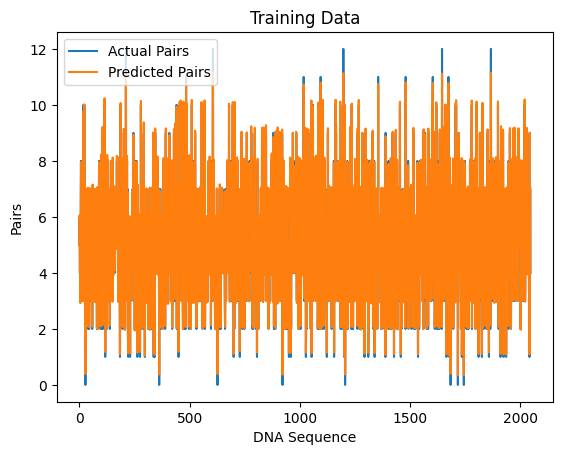

In [15]:
# Plotting comparision graph for actual vs predicted values
import matplotlib.pyplot as plt

with torch.no_grad():
    predicted = model(train_x.to(device)).to('cpu').numpy()

plt.plot(train_y, label='Actual Pairs')
plt.plot(predicted, label='Predicted Pairs')
plt.xlabel('DNA Sequence')
plt.ylabel('Pairs')
plt.title('Training Data')
plt.legend()
plt.show()

In [16]:
# Checking testing accuracy here
with torch.no_grad():
  predicted=model(test_x.to(device)).to('cpu').numpy()

predicted=np.round(predicted)
predicted=predicted.astype(int)
a=test_y.numpy()
a=a.astype(int)
score = 0

for i in range(len(predicted)):
  if predicted[i].item()==a[i].item():
    score+=1

print(f'Testing Accuracy: {score*100/len(predicted):.4f}%')

Testing Accuracy: 99.8047%


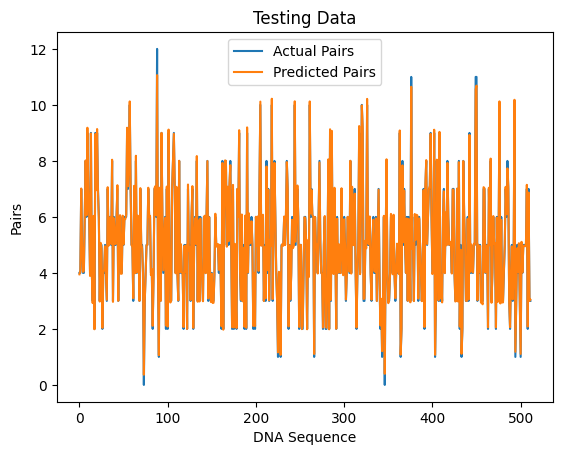

In [17]:
# Plotting comparision graph for actual vs predicted values
import matplotlib.pyplot as plt

with torch.no_grad():
    predicted = model(test_x.to(device)).to('cpu').numpy()

plt.plot(test_y, label='Actual Pairs')
plt.plot(predicted, label='Predicted Pairs')
plt.xlabel('DNA Sequence')
plt.ylabel('Pairs')
plt.title('Testing Data')
plt.legend()
plt.show()

In [18]:
# Defining a simple function to take string input and returning the integer output
def Get_output(sample):
  real_target = count_cpgs(sample)

  numerical=[dna2int[i] for i in sample]

  encoding = [[[1 if i == value else 0 for i in range(num_classes)] for value in numerical]]

  encoding=np.array(encoding)
  encoding = torch.tensor(encoding).float()

  encoding.shape, real_target
  with torch.no_grad():
      predicted_target = model(encoding.to(device)).to('cpu').numpy()

  return f'Predicted output: {predicted_target.item():.2f}, Real output: {real_target}'

Get_output(sample2)

'Predicted output: 4.99, Real output: 5'

# Part 2: what if the DNA sequences are not the same length

In [1]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random
import torch.nn as nn

In [2]:
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [3]:
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # Need to call rand_sequence_var_len and count_cpgs here to create the dataset

    # Step 1: Generate variable-length integer sequences
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))

    # Step 2: Convert integer sequences to DNA sequences (ensure string output)
    temp = [''.join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs_train]

    # Step 3: Count "CG" pairs in DNA sequences
    y_dna_seqs = [count_cpgs(seq) for seq in temp]

    # Code to pad the sequences to the maximum length
    X_dna_seqs_train_padded = [torch.tensor([dna2int[n] for n in seq]) for seq in temp]
    X_dna_seqs_train_padded = pad_sequence(X_dna_seqs_train_padded, batch_first=True, padding_value=dna2int["pad"])

    return X_dna_seqs_train_padded, torch.tensor(y_dna_seqs).float()


min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [4]:
#Generating a sample from the test data to use later to make predictions
sample3 = test_x[0].tolist()

# Map integers to DNA sequences
sample3 = list(intseq_to_dnaseq(sample3))

# Filter out "<pad>" elements
sample3 = [dna for dna in sample3 if dna != "<pad>"]

# Convert list to string
sample3 = ''.join(sample3)

sample3, len(sample3), count_cpgs(sample3)

('TGNCCGANCTCGGCANCGTCTNNCTGANTATNNNTCNTACGCGTCTAAANTATTTGATNGTGNGTNCNTGCNGATAGT',
 78,
 5)

In [5]:
# Define the number of classes
# 6 classes, 5 for the DNA nucleotides and 1 for the padded value
num_classes = 6

# Convert each element in the original_data to one-hot encoding
train_x= [[[1 if i == value else 0 for i in range(num_classes)] for value in sublist] for sublist in train_x]
test_x= [[[1 if i == value else 0 for i in range(num_classes)] for value in sublist] for sublist in test_x]

In [6]:
# Converting data to torch tensors

train_x=np.array(train_x)
train_y=np.array(train_y)
test_x=np.array(test_x)
test_y=np.array(test_y)

# train_x=train_x.reshape((-1,128,1))
train_y=train_y.reshape((-1,1))
# test_x=test_x.reshape((-1,128,1))
test_y=test_y.reshape((-1,1))

train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
test_x = torch.tensor(test_x).float()
test_y = torch.tensor(test_y).float()

train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([2048, 128, 6]),
 torch.Size([2048, 1]),
 torch.Size([512, 128, 6]),
 torch.Size([512, 1]))

In [7]:
#  To organize and encapsulate the data in a way that is compatible with PyTorch's data loading utility

from torch.utils.data import Dataset, DataLoader

class DNA_Sequence(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = DNA_Sequence(train_x, train_y)
test_dataset = DNA_Sequence(test_x, test_y)

# Create data loaders for training and test data
batch_size=32
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Select the device, make sure that cuda is available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [9]:
# To check the shape after fitting the data in data loader
for _, batch in enumerate(train_data_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 128, 6]) torch.Size([32, 1])


In [10]:
# The LSTM model used for prediction
import torch
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self, input_size=6, cnn_channels=128, kernel_size=2, hidden_size=128, num_stacked_layers=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        # 2 CNN layers
        self.conv1d_1 = nn.Conv1d(input_size, cnn_channels, kernel_size)
        self.relu_1 = nn.ReLU()
        self.maxpool_1 = nn.MaxPool1d(kernel_size=1)

        self.conv1d_2 = nn.Conv1d(cnn_channels, cnn_channels, kernel_size)
        self.relu_2 = nn.ReLU()
        self.maxpool_2 = nn.MaxPool1d(kernel_size=1)

        # LSTM layer
        self.lstm = nn.LSTM(126, hidden_size, num_stacked_layers,
                            batch_first=True, dropout=0.5, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size*2, 1)
        self.dropout = nn.Dropout(0.2)

        # The CNN layers are esential as they act as a feature extraction, we can use these features from the CNN layer as an input to the LSTM
        # Finally a linear layer is used as we need a single output
        # Dropout is required to avoid overfitting of data
        # Bidirectional LSTM model is used for better efficiency

    def forward(self, x):
        batch_size = x.size(0)

        # CNN forward pass
        x = x.permute(0, 2, 1)  # Change the shape for 1D convolution

        x = self.conv1d_1(x)
        x = self.relu_1(x)
        x = self.maxpool_1(x)

        x = self.conv1d_2(x)
        x = self.relu_2(x)
        x = self.maxpool_2(x)

        # LSTM forward pass
        # Initial hidden and cell states for the LSTM layer
        h0 = torch.zeros(self.num_stacked_layers*2, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers*2, batch_size, self.hidden_size).to(device)

        out_lstm, _ = self.lstm(x, (h0, c0))

        # Fully connected layer
        out=self.dropout(out_lstm[:,-1,:])
        out = self.fc(out)

        return out

# Example usage
model = CNN_LSTM()
model.to(device)
model


CNN_LSTM(
  (conv1d_1): Conv1d(6, 128, kernel_size=(2,), stride=(1,))
  (relu_1): ReLU()
  (maxpool_1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv1d_2): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (relu_2): ReLU()
  (maxpool_2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(126, 128, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [11]:
# Creating the training loop
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_data_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 9:  # print every 100 batches
            avg_loss_across_batches = running_loss / 10
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [12]:
# Creating the testing loop
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_data_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_data_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [13]:
# Training the model here
# Ensure that GPU is available for fast training. Around 1 minute for GPU training and 1.5 hrs for CPU training
learning_rate = 0.0002
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 10, Loss: 16.312
Batch 20, Loss: 15.967
Batch 30, Loss: 11.845
Batch 40, Loss: 4.263
Batch 50, Loss: 3.740
Batch 60, Loss: 3.546

Val Loss: 3.908
***************************************************

Epoch: 2
Batch 10, Loss: 3.468
Batch 20, Loss: 4.010
Batch 30, Loss: 3.516
Batch 40, Loss: 4.161
Batch 50, Loss: 3.555
Batch 60, Loss: 3.684

Val Loss: 3.895
***************************************************

Epoch: 3
Batch 10, Loss: 3.385
Batch 20, Loss: 3.660
Batch 30, Loss: 4.037
Batch 40, Loss: 3.282
Batch 50, Loss: 3.603
Batch 60, Loss: 3.964

Val Loss: 3.892
***************************************************

Epoch: 4
Batch 10, Loss: 3.708
Batch 20, Loss: 3.266
Batch 30, Loss: 3.803
Batch 40, Loss: 3.906
Batch 50, Loss: 3.608
Batch 60, Loss: 3.331

Val Loss: 3.689
***************************************************

Epoch: 5
Batch 10, Loss: 3.673
Batch 20, Loss: 3.174
Batch 30, Loss: 3.365
Batch 40, Loss: 3.523
Batch 50, Loss: 2.979
Batch 60, Loss: 3.319

Val Loss: 3

In [14]:
# Checking training accuracy
with torch.no_grad():
  predicted=model(train_x.to(device)).to('cpu').numpy()

predicted=np.round(predicted)
predicted=predicted.astype(int)
a=train_y.numpy()
a=a.astype(int)
score = 0

for i in range(len(predicted)):
  if predicted[i].item()==a[i].item():
    score+=1

print(f'Training Accuracy: {score*100/len(predicted):.4f}%')

Training Accuracy: 99.9512%


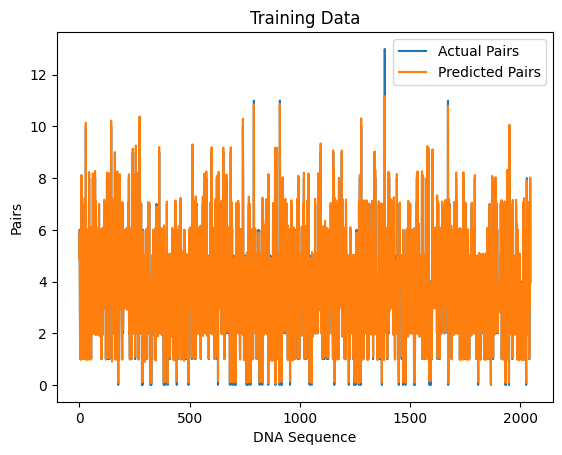

In [15]:
# Plotting comparision graph for actual vs predicted values
import matplotlib.pyplot as plt

with torch.no_grad():
    predicted = model(train_x.to(device)).to('cpu').numpy()

plt.plot(train_y, label='Actual Pairs')
plt.plot(predicted, label='Predicted Pairs')
plt.xlabel('DNA Sequence')
plt.ylabel('Pairs')
plt.title('Training Data')
plt.legend()
plt.show()

In [16]:
# Checking testing accuracy here
with torch.no_grad():
  predicted=model(test_x.to(device)).to('cpu').numpy()

predicted=np.round(predicted)
predicted=predicted.astype(int)
a=test_y.numpy()
a=a.astype(int)
score = 0

for i in range(len(predicted)):
  if predicted[i].item()==a[i].item():
    score+=1

print(f'Testing Accuracy: {score*100/len(predicted):.4f}%')

Testing Accuracy: 100.0000%


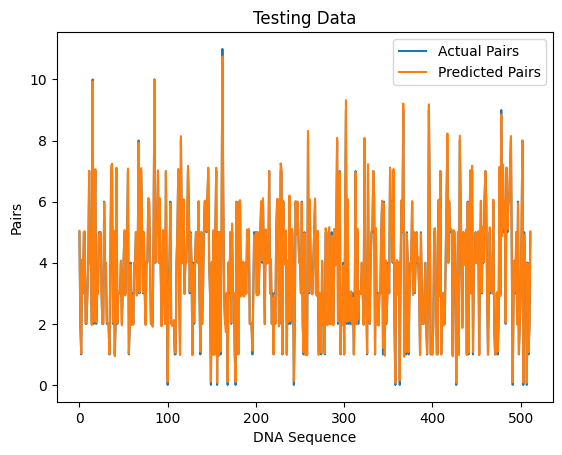

In [17]:
# Plotting comparision graph for actual vs predicted values
import matplotlib.pyplot as plt

with torch.no_grad():
    predicted = model(test_x.to(device)).to('cpu').numpy()

plt.plot(test_y, label='Actual Pairs')
plt.plot(predicted, label='Predicted Pairs')
plt.xlabel('DNA Sequence')
plt.ylabel('Pairs')
plt.title('Testing Data')
plt.legend()
plt.show()

In [18]:
# Defining a simple function to take string input and returning the integer output

def Get_output(sample):

  real_target = count_cpgs(sample)

  numerical=[dna2int[i] for i in sample]

  temp = [''.join(intseq_to_dnaseq(seq)) for seq in [numerical]]

  temp = [torch.tensor([dna2int[n] for n in seq]) for seq in temp]
  temp = pad_sequence(temp, batch_first=True, padding_value=dna2int["pad"])

  temp = torch.nn.functional.pad(temp, (0, 128 - temp.size(1)), value=0)

  encoding = [[[1 if i == value else 0 for i in range(num_classes)] for value in row] for row in temp]

  encoding=np.array(encoding)
  encoding = torch.tensor(encoding).float()

  with torch.no_grad():
      predicted_target = model(encoding.to(device)).to('cpu').numpy()

  return f'Predicted output: {predicted_target.item():.2f}, Real output: {real_target}'

Get_output(sample3)

'Predicted output: 5.05, Real output: 5'

In [19]:
# Saving the trained LSTM model
torch.save(model.state_dict(), "my_model.pth")

# Streamlit WebApp

In [20]:
# !pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [21]:
# Creating an app file
%%writefile app.py

Writing app.py


In [22]:
# import streamlit as st
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# from functools import partial

# class CNN_LSTM(nn.Module):
#     def __init__(self, input_size=6, cnn_channels=128, kernel_size=2, hidden_size=128, num_stacked_layers=3):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_stacked_layers = num_stacked_layers

#         # 4 CNN layers
#         self.conv1d_1 = nn.Conv1d(input_size, cnn_channels, kernel_size)
#         self.relu_1 = nn.ReLU()
#         self.maxpool_1 = nn.MaxPool1d(kernel_size=1)

#         self.conv1d_2 = nn.Conv1d(cnn_channels, cnn_channels, kernel_size)
#         self.relu_2 = nn.ReLU()
#         self.maxpool_2 = nn.MaxPool1d(kernel_size=1)

#         # LSTM layer
#         self.lstm = nn.LSTM(126, hidden_size, num_stacked_layers,
#                             batch_first=True, dropout=0.5, bidirectional=True)

#         # Fully connected layer
#         self.fc = nn.Linear(hidden_size*2, 1)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         batch_size = x.size(0)

#         # CNN forward pass
#         x = x.permute(0, 2, 1)  # Change the shape for 1D convolution

#         x = self.conv1d_1(x)
#         x = self.relu_1(x)
#         x = self.maxpool_1(x)

#         x = self.conv1d_2(x)
#         x = self.relu_2(x)
#         x = self.maxpool_2(x)

#         # LSTM forward pass
#         # Initial hidden and cell states for the LSTM layer
#         h0 = torch.zeros(self.num_stacked_layers*2, batch_size, self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_stacked_layers*2, batch_size, self.hidden_size).to(device)

#         out_lstm, _ = self.lstm(x, (h0, c0))

#         # Fully connected layer
#         out=self.dropout(out_lstm[:,-1,:])
#         out = self.fc(out)

#         return out

# # Load the saved PyTorch model
# model_path = 'my_model.pth'
# loaded_model = CNN_LSTM()
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model.eval()

# def count_cpgs(seq: str) -> int:
#     cgs = 0
#     for i in range(0, len(seq) - 1):
#         dimer = seq[i:i+2]
#         # note that seq is a string, not a list
#         if dimer == "CG":
#             cgs += 1
#     return cgs

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# # Alphabet helpers
# alphabet = 'NACGT'
# dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
# int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
# dna2int.update({"pad": 0})
# int2dna.update({0: "<pad>"})

# intseq_to_dnaseq = partial(map, int2dna.get)
# dnaseq_to_intseq = partial(map, dna2int.get)

# def Get_output(sample):

#   real_target = count_cpgs(sample)

#   numerical=[dna2int[i] for i in sample]

#   temp = [''.join(intseq_to_dnaseq(seq)) for seq in [numerical]]

#   temp = [torch.tensor([dna2int[n] for n in seq]) for seq in temp]
#   temp = pad_sequence(temp, batch_first=True, padding_value=dna2int["pad"])

#   temp = torch.nn.functional.pad(temp, (0, 128 - temp.size(1)), value=0)

#   encoding = [[[1 if i == value else 0 for i in range(6)] for value in row] for row in temp]

#   encoding=np.array(encoding)
#   encoding = torch.tensor(encoding).float()

#   encoding=encoding.to(device)

#   with torch.no_grad():

#       loaded_model.to(device)
#       predicted_target = loaded_model(encoding.to(device)).to('cpu').numpy()

#   return f'Model output: {predicted_target.item():.2f}, Prediction: {np.round(predicted_target.item())}, Real output: {real_target}'

# # Streamlit app title
# url = 'https://mms.businesswire.com/media/20231205434728/en/1959728/22/Logo_1.jpg'
# st.image(url, width=200)
# st.title("DNA Sequence CpGs Prediction")

# # User input
# user_input = st.text_input("Enter your input:", "Enter DNA Sequence here...")


# # Check if the user has pressed Enter
# if st.button("Predict"):

#   if user_input=="":
#     st.write("Please enter DNA Sequence")
#   else:
#     with torch.no_grad():
#         prediction = Get_output(user_input)

#     # Display the prediction
#     st.write(prediction)

#     centered_gif = '''
# <div style="display: flex; justify-content: center; align-items: center; height: 30vh;">
#     <img src="https://media.giphy.com/media/scZPhLqaVOM1qG4lT9/giphy.gif" alt="Gif" width="200">
# </div>
# '''
#     st.markdown(centered_gif, unsafe_allow_html=True)

# else:
#   centered_gif = '''
# <div style="display: flex; justify-content: center; align-items: center; height: 30vh;">
#     <img src="https://media.giphy.com/media/QDjpIL6oNCVZ4qzGs7/giphy.gif" alt="Funny Gif" width="200">
# </div>
# '''
#   st.markdown(centered_gif, unsafe_allow_html=True)

In [23]:
# Copy the address generated here on the website
! wget -q -O - ipv4.icanhazip.com

34.148.98.229


In [ ]:
# Use the address copied above on the url generated here
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.148.98.229:8501

Need to install the following packages:
  localtunnel@2.0.2
Ok to proceed? (y) y
your url is: https://olive-laws-mate.loca.lt


# Thank You!!